RGB
image size:  (256, 256)


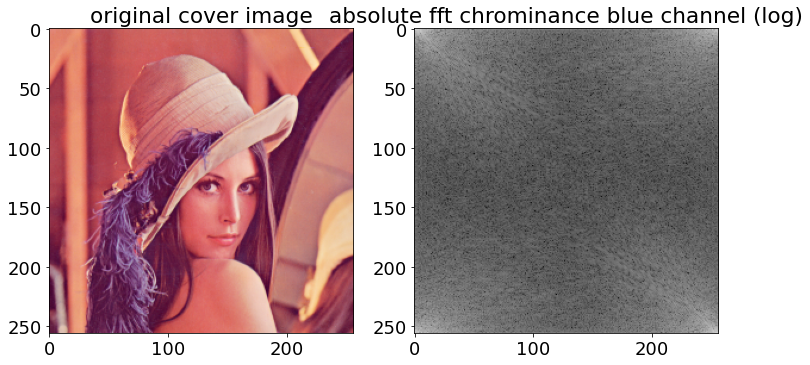

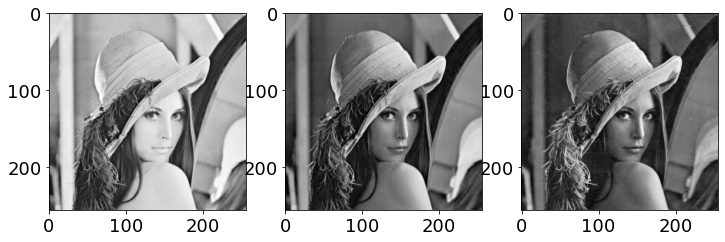

In [3]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = [12,8]
plt.rcParams.update({'font.size':18})

# creating a object 
# PATH = "ImageSources\\jfif\\darth_vader.jfif"
# PATH = "ImageSources\\jfif\\the_rock.jfif"
# PATH = "ImageSources\\jfif\\obi-wan_kenobi.jfif"
# PATH = "ImageSources\\jpg\\iron_patriot.jpg"
# PATH = "ImageSources\\png\\r2d2.png"
cover_img_path = "ImageSources\\tif\\lena_color_256.tif"
image = Image.open(cover_img_path)
image.load()

image = image.convert("YCbCr")

# Rot, Grün, Blau= image.split() #split image into its RGB channels
channel0, channel1, channel2 = image.split()

print("image size: ",image.size)

plt.figure()
plt.subplot(121)
plt.imshow(image)
plt.title("original cover image")

fft_abs = 10*np.log10(np.abs(np.fft.fft2(channel1)))
plt.subplot(122)
plt.imshow(fft_abs, cmap="gray")
plt.title("absolute fft chrominance blue channel (log)")
plt.figure()
plt.subplot(131)
plt.imshow(channel0, cmap="gray")
plt.subplot(132)
plt.imshow(channel1, cmap="gray")
plt.subplot(133)
plt.imshow(channel2, cmap="gray")

Functions for encoding and decoding

In [10]:
string="""It's about drive, it's about power
We stay hungry, we devour 💪😄
Put in the work, put in the hours and take what's ours (ahoo)
Black and Samoan in my veins
My culture bangin' with Strange
I change the game, so what's my motherfuckin' name (Rock)
(What they gonna get though?)
Desecration, defamation, if you wanna bring it to the masses
Face to face, now we escalatin', when I have to put boots to asses
Mean on ya, like a dream when I'm rumblin', you're gonna scream mama
So bring drama to the King Brahma (then what?) 
Comin' at you with extreme mana
"""
# string="""Lorem ipsum dolor sit amet, consetetur sadipscing elitr, sed diam nonumy eirmod tempor invidunt ut labore et dolore magna aliquyam"""

""" string version """
def text_to_bits(text, encoding='utf-8', errors='surrogatepass'):
    bits = bin(int.from_bytes(text.encode(encoding, errors), 'big'))[2:]
    return bits.zfill(8 * ((len(bits) + 7) // 8))

def text_from_bits(bits, encoding='utf-8', errors='surrogatepass'):
    n = int(bits,2)
    return n.to_bytes((n.bit_length() + 7) // 8, 'big').decode(encoding, errors) or '\0'

    
""" int version """
def text_to_bits_int(text, gain):
    string_bits = text_to_bits(text)
    # convert each char to int
    message_bits = [int(i)*gain for i in string_bits]
    # get length of bitstream as bytes (overflow error if too large)
    formated = bin(len(message_bits))[2:]
    while len(formated) < 16:
        formated = '0' + formated
    message_len = [int(j)*gain for j in formated]
    # append length onto the first 2 bytes of the message
    message_bits = message_len + message_bits
    return message_bits


def text_from_bits_int(bits):
    # convert each element to string
    message_len_bits = bits[:16]
    message_len = ""
    for bit in message_len_bits:
        message_len = message_len + str(bit)
    message_len = int(message_len, 2)
    string_bits = [str(i) for i in bits[16:message_len+16]]
    string_concat = ""
    # concatenate each element to one string
    for string in string_bits:
        string_concat += string
    string_decode = text_from_bits(string_concat)
    return string_decode, message_len

# normalize a channel by its max and min values
def convert(img, target_type_min, target_type_max, target_type):
    imin = img.min()
    imax = img.max()

    a = (target_type_max - target_type_min) / (imax - imin)
    b = target_type_max - a * imax
    new_img = (a * img + b).astype(target_type)
    return new_img


# convert inverse transformed message to parsable binary message
def message2bin(message, threshold):
    digital = np.zeros(len(message)).astype('uint8')
    for ix, m in enumerate(message):
        if m > threshold:
            digital[ix] = 1
        else:
            digital[ix] = 0
    return digital

Embed hidden message inside the absolute spektrum of the Fourier-Transform and reverse the process to save the resulting image as .png

MASK:

bin_encoded: [0, 0, 0, 50000, 0, 0, 0, 50000, 0, 50000, 50000, 50000, 0, 0, 0, 0, 0, 50000, 0, 0]
cut:  0.3808476360370378
message length: 4480
confirm: 4802.0


C:\Users\maxik\AppData\Local\Temp/ipykernel_31388/2011465706.py:38: RuntimeWarning: divide by zero encountered in log10
  im = Image.fromarray(10*np.log10(cover_fft_masked))


Text(0.5, 1.0, 'Red channel in frequency domain, filtered with mask (log)')

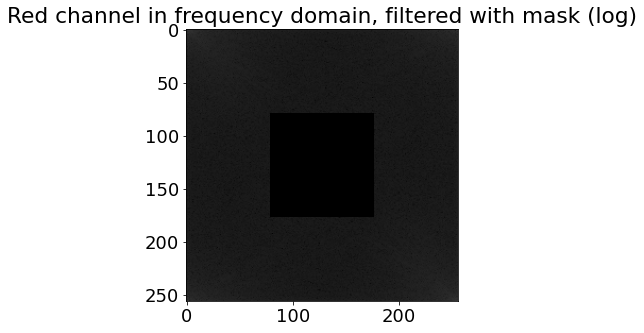

In [11]:
gain = 50000
bin_encoded =  text_to_bits_int(string, gain)
print("bin_encoded:", bin_encoded[:20])

def create_FFTmask(columns, rows, message, optcut = None):
    # calculate minimum part to be cut and add another 3% because of rounding errors and for "safety"
    cut = np.sqrt(2*len(message)/(rows*columns))*1.03
    if cut > 0.7:
        raise Exception("The message is too large. Major distortions are to be expected.")
    if not optcut:
        if cut > 0.4:
            raise Exception("The message is too large. Major distortions are to be expected.")
        else:
            cut = 0.4

    #cut off high frequencies from R channel
    mask = np.full((rows, columns), True)
    row_start = round(rows/2*(1-cut))
    row_stop = round(rows/2*(1+cut))
    col_start = round(columns/2*(1-cut))
    col_stop = round(columns/2*(1+cut))
    mask[row_start:row_stop, col_start:col_stop] = False  # rectangular

    # x-length of the mask
    x_len_mask = col_stop - col_start 
    # y-length of the mask
    y_len_mask = row_stop - row_start 

    print("cut: ", cut)
    print("message length:", len(message))
    print("confirm:", x_len_mask*y_len_mask/2)

    return mask, cut

cover_fft_mask, cut = create_FFTmask(*(image.size), bin_encoded, True)

cover_fft_masked = np.abs(np.fft.fft2(channel1))*cover_fft_mask
im = Image.fromarray(10*np.log10(cover_fft_masked))
plt.figure(figsize=(5,5))
plt.imshow(im)
plt.title("Red channel in frequency domain, filtered with mask (log)")

C:\Users\maxik\AppData\Local\Temp/ipykernel_31388/3250837892.py:21: RuntimeWarning: divide by zero encountered in log10
  im = Image.fromarray(10*np.log10(fft_abs))


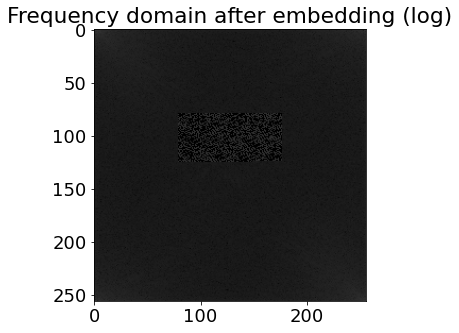

In [12]:
def embedBin2FFT(cover_channel, mask, message):
    fft = np.fft.fft2(cover_channel)
    fft_abs = np.abs(fft)
    ylength, xlength = fft_abs.shape
    
    # write hidden message into filtered absolute part
    counter=0
    for i in range(ylength):
        # if cover_rows == 50:
        #     print("max values", np.max(cover_r_fft_abs[i]))
        for j in range(xlength):
            # write where coefficients are zero -> previously filtered out.
            if mask[i,j]==0:
                if counter<len(message):
                    # write hidden message inside absolute part by overwriting coefficients where the mask is 0
                    fft_abs[i,j]=message[counter]
                    # print(cover_r_fft_abs[i,j])
                    counter+=1

    # plot absolute after embedding information
    im = Image.fromarray(10*np.log10(fft_abs))
    plt.figure(figsize=(5,5))
    plt.imshow(im)
    plt.title("Frequency domain after embedding (log)")

    #IFFT on single channel. Take filtered absolute and inverse with original phase, imaginary part should be negligable
    cover_masked = np.fft.ifft2(fft_abs*np.exp(1j*np.angle(fft))).real
    return cover_masked

# get channel with embedded binary data
cover_masked = embedBin2FFT(channel1, cover_fft_mask, bin_encoded)

# normalize output
cover_masked_clip = np.clip(cover_masked, 0,255).astype("uint8")
# cover_r_masked_norm = convert(cover_r_masked, 0,255, np.uint8)

# merge layers
stego =  np.stack((channel0, cover_masked_clip, channel2), axis=2).astype('uint8')
# create steganogram
stego_img = Image.fromarray(stego, "YCbCr").convert("RGB")

Plot histograms

-61.081391405464885
259.03800762896975


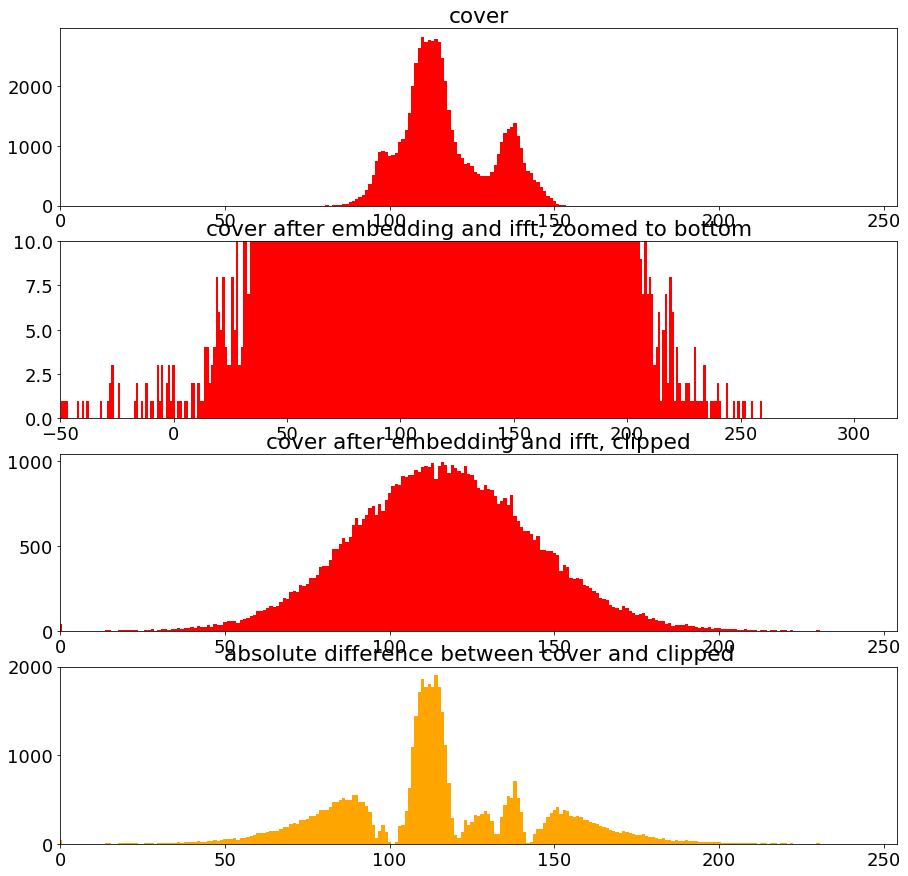

In [13]:
hist0, edges0 = np.histogram(np.array(channel1), bins=range(255))
plt.figure(figsize=(15,15))
plt.subplot(411)
plt.bar(edges0[:-1], hist0, width = 1, color='red')
plt.xlim(min(edges0), max(edges0))
plt.title("cover")

hist1, edges1 = np.histogram(cover_masked, bins=range(-50,320))
plt.subplot(412)
plt.bar(edges1[:-1], hist1, width = 1, color='red')
plt.xlim(min(edges1), max(edges1))
plt.ylim(0,10)
plt.title("cover after embedding and ifft, zoomed to bottom")
print(np.min(cover_masked))
print(np.max(cover_masked))

hist2, edges2 = np.histogram(cover_masked_clip, bins=range(255))
plt.subplot(413)
plt.bar(edges2[:-1], hist2, width = 1, color='red')
plt.xlim(min(edges2), max(edges2))
plt.title("cover after embedding and ifft, clipped")

hist3 = np.abs(np.subtract(hist0,hist2))
plt.subplot(414)
plt.bar(edges2[:-1], hist3, width = 1, color='orange')
plt.xlim(min(edges2), max(edges2))
plt.title("absolute difference between cover and clipped")

plt.show()

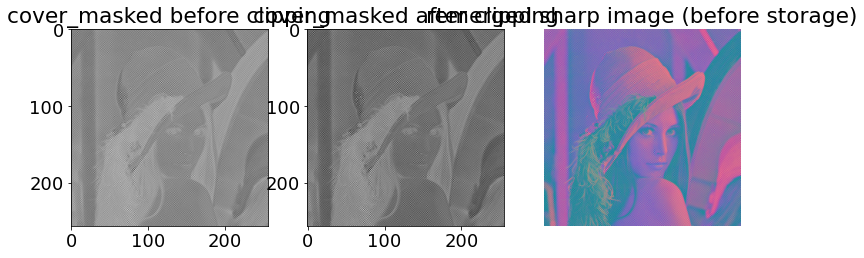

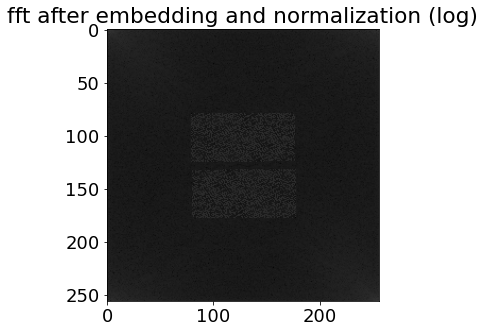

image saved


In [14]:
# some plots
plt.figure()
plt.subplot(131)
plt.imshow(cover_masked, cmap="gray")
plt.title("cover_masked before clipping")
plt.subplot(132)
plt.imshow(cover_masked_clip, cmap="gray")
plt.title("cover_masked after clipping")
plt.subplot(133)
plt.axis('off')
plt.imshow(stego_img) #Show picture with embeddes secret message
plt.title("remerged sharp image (before storage)")



sanity_check = Image.fromarray(10*np.log10(np.abs(np.fft.fft2(cover_masked_clip))))
plt.figure(figsize=(5,5))
plt.imshow(sanity_check, cmap="gray")
plt.title("fft after embedding and normalization (log)")

plt.show()

im = stego_img.save("ImageSources\\Steganograms\\remerged_sharp.png")     #save image as png
print("image saved")

Calculate mask from cut variable

max value stego_r:
 238


Text(0.5, 1.0, 'calculated fft mask')

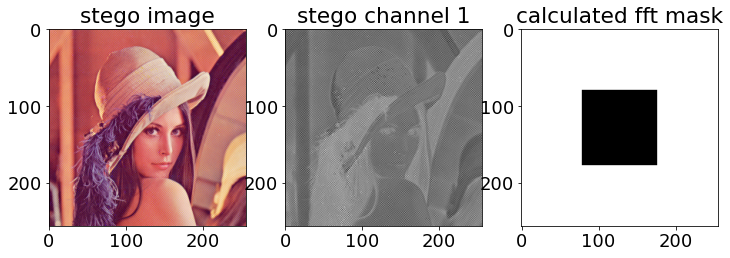

In [33]:
# load and plot image
stego_img = Image.open("ImageSources\\Steganograms\\remerged_sharp.png").convert("YCbCr")

plt.figure()
plt.subplot(131)
plt.imshow(stego_img)
plt.title("stego image")

steg_channel0, steg_channel1, steg_channel2 = stego_img.split() #split image into its RGB channels

plt.subplot(132)
plt.imshow(steg_chromB, cmap="gray")
plt.title("stego channel 1")

print("max value stego_r:\n", np.max(steg_channel1))

# calculate mask
def calculate_FFTmask(columns, rows, cut = None):
    if not cut:
        cut = 0.4
    stego_fft_mask = np.full((rows, columns), True)
    row_start = round(rows/2*(1-cut))
    row_stop = round(rows/2*(1+cut))
    col_start = round(columns/2*(1-cut))
    col_stop = round(columns/2*(1+cut))
    stego_fft_mask[row_start:row_stop, col_start:col_stop] = False  # rectangular

    return stego_fft_mask

stego_fft_mask = calculate_FFTmask(*(stego_img.size), cut)

plt.subplot(133)
plt.imshow(stego_fft_mask, cmap="gray")
plt.title("calculated fft mask")

predicted message length:  4802
[  437   750   338 24705  1049   459   958 23995   776 23703 24557 24733
   496   672   593   743  1257 23580   606  1007]
threshold 13327.0
binary [0 0 0 1 0 0 0 1 0 1 1 1 0 0 0 0 0 1 0 0]
parsed message length 4464
bin_decoded:
It's about drive, it's about power
We stay hungry, we devour 💪😄
Put in the work, put in the hours and take what's ours (ahoo)
Black and Samoan in my veins
My culture bangin' with Strange
I change the game, so what's my motherfuckin' name (Rock)
(What they gonna get though?)
Desecration, defamation, if you wanna bring it to the masses
Face to face, now we escalatin', when I have to put boots to asses
Mean on ya, like a dream when I'm rumblin', you're gonna scream mama
So bring drama to the King Brahma (then what?) 
Comin' at you with extreme mana



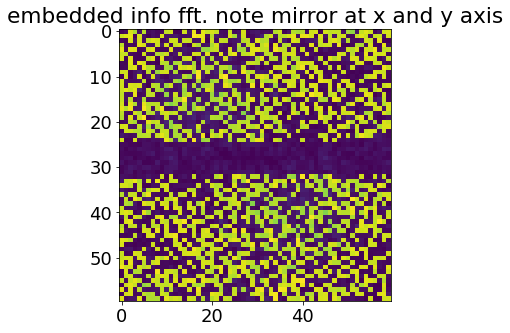

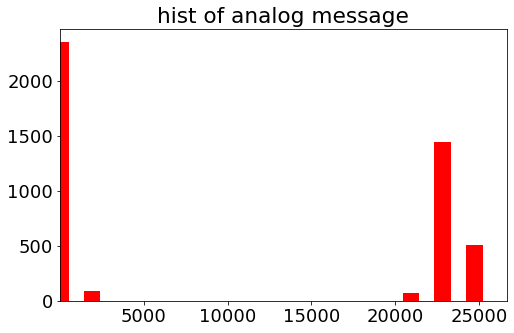

In [35]:
def get_message(stego_channel, mask):
    # transform R channel into frequency domain
    stego_fft =np.fft.fft2(stego_channel)
    stego_fft_abs = np.abs(stego_fft)
    ylen, xlen = stego_fft_abs.shape

    plt.figure(figsize=(5,5))
    plt.imshow(stego_fft_abs[100:160, 100:160])
    plt.title("embedded info fft. note mirror at x and y axis")
    
    # calculate message length from mask -> predicted message length > true message length!
    message_length = int(np.count_nonzero(mask == False)//2)  #add buffer of 10%
    print("predicted message length: ", message_length)

    # create message buffer
    message=np.zeros(message_length, dtype='uint32')
    counter=0
    for i in range(ylen):
        for j in range(xlen):
            if mask[i,j]==0:
                # loads also data not in the range of the hidden, but gets sliced off later
                if counter==message_length:
                    break
                message[counter] = stego_fft_abs[i,j]
                counter+=1 

    return message

message = get_message(steg_channel1, stego_fft_mask)

print(message[:20])

# calculate threshold
threshold = np.max(message)/2
print("threshold", threshold)

# convert message values to binary
binary = message2bin(message, threshold)
print("binary", binary[:20])  # first 2 bytes are length of the embedded message

# convert binary to utf-8
Text, length = text_from_bits_int(binary)
print("parsed message length", length)

# plot histogram
hist, edges = np.histogram(message[:length+16], bins="auto")
plt.figure(figsize=(8,5))
plt.bar(edges[:-1], hist, width = 1000, color='red')
plt.xlim(min(edges), max(edges))
plt.title("hist of analog message")

print("bin_decoded:")
print(Text)

#####################################################################################################################################################################################################################################
#####################################################################################################################################################################################################################################
#####################################################################################################################################################################################################################################

Now implement a gain finder algorithm

In [4]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from FFT_stego import *

plt.rcParams['figure.figsize'] = [10,10]
plt.rcParams.update({'font.size':18})

cover_img_path ="ImageSources\\tif\\lena_color_256.tif"

stego_img_path = stego_path_generator(cover_img_path, "png")
print(stego_img_path)
# input string
string=\
"""\
Lorem ipsum dolor sit amet, consetetur sadipscing elitr, sed diam nonumy eirmod tempor invidunt ut labore et dolore magna aliquyam erat, sed diam voluptua.
At vero eos et accusam et justo duo dolores et ea rebum. Stet clita kasd gubergren, no sea takimata sanctus est Lorem ipsum dolor sit amet.
Lorem ipsum dolor sit amet, consetetur sadipscing elitr, sed diam nonumy eirmod tempor invidunt ut labore et dolore magna aliquyam erat, sed diam voluptua.
At vero eos et accusam et justo duo dolores et ea rebum. Stet clita kasd gubergren, no sea takimata sanctus est Lorem ipsum dolor sit amet.\
"""

cut = steg_encode_simple(cover_img_path, string, True, colorspace="YCbCr")

Text = steg_decode(cut)
print("parsed text:\n", Text)
print("cut value:", cut)

c:\Users\maxik\Documents\Semester_6\Projektarbeit\github_repo\Steganography\ImageSources\Steganograms\lena_color_256_steg.png
gain	 10000 	text	 Lorem ipsu
parsed text:
 Lorem ipsum dolor sit amet, consetetur sadipscing elitr, sed diam nonumy eirmod tempor invidunt ut labore et dolore magna aliquyam erat, sed diam voluptua.
At vero eos et accusam et justo duo dolores et ea rebum. Stet clita kasd gubergren, no sea takimata sanctus est Lorem ipsum dolor sit amet.
Lorem ipsum dolor sit amet, consetetur sadipscing elitr, sed diam nonumy eirmod tempor invidunt ut labore et dolore magna aliquyam erat, sed diam voluptua.
At vero eos et accusam et justo duo dolores et ea rebum. Stet clita kasd gubergren, no sea takimata sanctus est Lorem ipsum dolor sit amet.
cut value: 0.3919084228669531


Works with the following image file formats:
*   png
*   bmp
*   tiff
*   webp (not recommended)